In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

linestyles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'd'] 
selected_font_size = 22
output_dir_base_path = f'/home/rob/Documents/3_projects/bench/analysis_tmlr_updates/graphs/'
os.makedirs(output_dir_base_path, exist_ok=True)

def construct_path_from_parent(root_dir, subdir_list):
    return os.path.join(root_dir, *subdir_list)

def build_path(dataset_name: str, model_name: str, fold_nb: str, model_size: str, small_data: bool = False, 
               root_base_dir: str = '/home/rob/Documents/3_projects/bench/_results') -> str:
    root_dir = os.path.join(root_base_dir, 'ten_percent' if small_data else '', model_size)
    subdirs = [dataset_name, model_name, fold_nb, "summary.json"]
    summary_loc = construct_path_from_parent(root_dir, subdirs)
    if not os.path.exists(summary_loc):
        print(f'No file at the path provided: {summary_loc}.')
    return summary_loc

# Function to load and process model data
def load_model_data(model_names, folds, dataset_name, model_size, small_data=False):
    model_dicts = {}
    for model_name in model_names:
        model_dicts[model_name] = {}
        metric_time_dict = {}
        for fold in folds:
            metric_time_dict[fold] = {}
            summary_loc = build_path(dataset_name, model_name, fold, model_size, small_data)
            with open(summary_loc) as file:
                data = json.load(file)
                
            # Extract performance and time data
            data_test = data.get('test', {})
            data_train = data.get('train', {})
            perf_list = data_test[perf_metric]
            time_list = data_train['time']
            
            metric_time_dict[fold]['perf'] = perf_list
            metric_time_dict[fold]['time'] = time_list
        
        model_dicts[model_name] = metric_time_dict
    return model_dicts

# Load data for both small and large models in both setups
model_size_small = 'small_models'
model_size_large = 'large_models'
model_names = ["UNet_vanilla", "UNet_e2cnn", "C8", "D4", "C16"]
folds = [f'fold_{i}' for i in range(5)]

#dataset_name = "kvasir"
#dataset_name = "NucleiSeg"
dataset_name = "URDE"
#dataset_name = "isaid"
#dataset_name = "coco"

perf_metric = 'IoU_score'
perf_metric_name = 'IoU Score'

# Load data for each configuration
model_data_small = load_model_data(model_names, folds, dataset_name, model_size_small)
model_data_large = load_model_data(model_names, folds, dataset_name, model_size_large)
model_data_small_small_setup = load_model_data(model_names, folds, dataset_name, model_size_small, small_data=True)
model_data_large_small_setup = load_model_data(model_names, folds, dataset_name, model_size_large, small_data=True)

# Function to calculate averages and cumulative time
def calculate_averages(model_dicts):
    averages_dict = {}
    for model_name in model_dicts.keys():
        all_perf_lists = [model_dicts[model_name][fold]['perf'] for fold in folds]
        all_time_lists = [model_dicts[model_name][fold]['time'] for fold in folds]
        
        perf_array = np.array(all_perf_lists)
        time_array = np.array(all_time_lists)
        
        avg_perf = np.mean(perf_array, axis=0) 
        avg_time = np.mean(time_array, axis=0) 
        cumulative_time = np.cumsum(avg_time)
        
        averages_dict[model_name] = {'avg_perf': avg_perf, 'cumulative_time': cumulative_time}
    return averages_dict

# Calculate averages
averages_small = calculate_averages(model_data_small)
averages_large = calculate_averages(model_data_large)
averages_small_small_setup = calculate_averages(model_data_small_small_setup)
averages_large_small_setup = calculate_averages(model_data_large_small_setup)



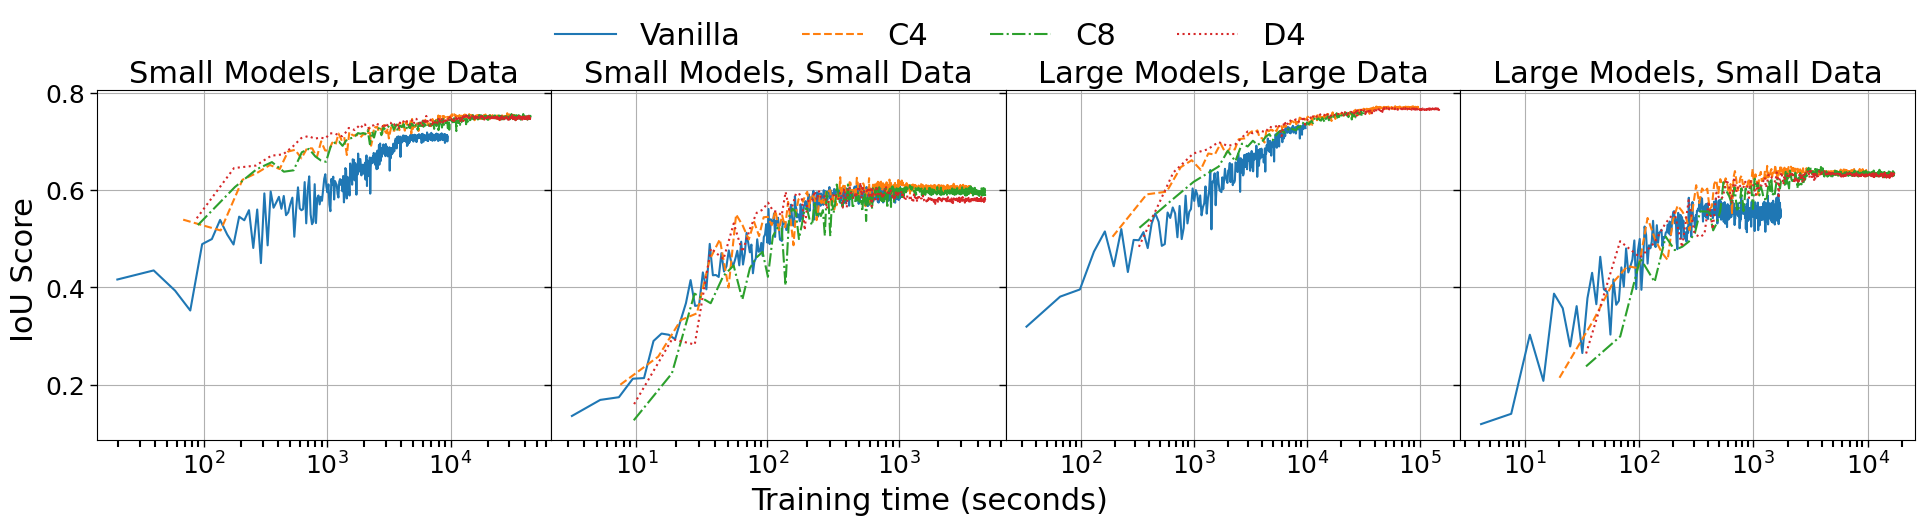

In [3]:
# Plotting all 4 setups side by side in a single row with minimal spacing using gridspec_kw
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5), sharey=True, gridspec_kw={'wspace': 0.0})

# Define a consistent set of line styles
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'd']  # Optional, if you want to add markers

for i, model_name in enumerate(model_names):
    linestyle = line_styles[i % len(line_styles)]  # Consistent line style across subplots
    display_name = 'C4' if model_name == 'UNet_e2cnn' else 'Vanilla' if model_name == 'UNet_vanilla' else model_name

    # Small Models, Large Data Setup
    avg_perf_small = averages_small[model_name]['avg_perf']
    cumulative_time_small = averages_small[model_name]['cumulative_time']
    ax1.plot(cumulative_time_small, avg_perf_small, label=display_name, linestyle=linestyle, linewidth=1.5, marker=None)
    
    # Small Models, Small Data Setup
    avg_perf_small_small = averages_small_small_setup[model_name]['avg_perf']
    cumulative_time_small_small = averages_small_small_setup[model_name]['cumulative_time']
    ax2.plot(cumulative_time_small_small, avg_perf_small_small, label=display_name, linestyle=linestyle, linewidth=1.5, marker=None)
    
    # Large Models, Large Data Setup
    avg_perf_large = averages_large[model_name]['avg_perf']
    cumulative_time_large = averages_large[model_name]['cumulative_time']
    ax3.plot(cumulative_time_large, avg_perf_large, label=display_name, linestyle=linestyle, linewidth=1.5, marker=None)
    
    # Large Models, Small Data Setup
    avg_perf_large_small = averages_large_small_setup[model_name]['avg_perf']
    cumulative_time_large_small = averages_large_small_setup[model_name]['cumulative_time']
    ax4.plot(cumulative_time_large_small, avg_perf_large_small, label=display_name, linestyle=linestyle, linewidth=1.5, marker=None)

# Configure each subplot
ax1.set_title('Small Models, Large Data', fontsize=selected_font_size)
ax2.set_title('Small Models, Small Data', fontsize=selected_font_size)
ax3.set_title('Large Models, Large Data', fontsize=selected_font_size)
ax4.set_title('Large Models, Small Data', fontsize=selected_font_size)

# Increase tick size for better readability
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xscale('log')
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=18, length=5, width=1.)  # Larger major ticks
    ax.tick_params(axis='both', which='minor', labelsize=18, length=5, width=1.5)  # Larger minor ticks

# Single shared y-axis and x-axis label
fig.text(0.04, 0.5, perf_metric_name, va='center', rotation='vertical', fontsize=selected_font_size)
fig.text(0.5, 0.02, 'Training time (seconds)', ha='center', fontsize=selected_font_size)

# Single legend for all plots, positioned slightly higher
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=len(model_names), fontsize=selected_font_size, frameon=False)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Adjust layout for better spacing
output_pdf = os.path.join(output_dir_base_path, f'{dataset_name}_4_plots_comparison.pdf')
plt.savefig(output_pdf, format='pdf', bbox_inches='tight')  # Ensure full content is saved

plt.show()
